In [1]:
### Preprocessing ###
# Data Loading
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases'
                 '/breast-cancer-wisconsin/wdbc.data', header=None)

In [3]:
# X, y 변수 스케일링
from sklearn.preprocessing import LabelEncoder
X = df.loc[:, 2:].values  # 30개의 feature를 할당
y = df.loc[:, 1].values
le = LabelEncoder() #one hot encoding이 아님. 0,1,2,3,4,5 등으로 class를 정함.
y = le.fit_transform(y)   # class [B, M]을 class [0, 1]로 전환
print(le.classes_)
print(le.transform(['M', 'B'])) # 확인  : b는 유방암이 없음.  m 은 유방암이 있음.

['B' 'M']
[1 0]


In [4]:
print(1-y.mean()) #최소한 이거보단 높는게 양심에맞음

0.6274165202108963


In [5]:
# 전체 data를 training data와 test data로 split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,
                                                    stratify=y, random_state=1) # 층을 y로 줘야 균형이 잡힌 데이터가 출력.

In [7]:
### Pipeline Streaming: 표준화 → PCA → Logistic Regression ###
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline # 여러가지 기법들을 동시에 적합시켜버리는게 pipeline
pipe_lr = make_pipeline(StandardScaler(), #표준화 -> pca -> logistic 돌리려고함.
                        PCA(n_components=4),
                        LogisticRegression(random_state=1, solver='lbfgs'))  # 적용 순서대로 나열
pipe_lr.fit(X_train, y_train)            # 표준화(fit → transform) → PCA(fit → transform) → Logistic Reg fit의 순서로 처리
y_train_pred = pipe_lr.predict(X_train)  # 표준화 transform → PCA transform → Logistic Reg prediction 순서로 처리
y_test_pred = pipe_lr.predict(X_test)

In [8]:
# Accuracy score
print(pipe_lr.score(X_train, y_train))  # Training accuracy
print(pipe_lr.score(X_test, y_test))    # Test accuracy       -> 거의 가깝게 출력된다.

0.967032967032967
0.956140350877193


In [13]:
### K-fold cross-validation using pipeline ###
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=pipe_lr, X=X_train, y=y_train, cv=10)  # Accuracy scores   # 10개의 fold로 쪼갬.
print('CV accuracy scores:\n %s ' % scores)

import numpy as np
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores))) #10개의 mean , sd임. 단 우리는 hyperparameter을 결정하려고 
                                                                        #꺼낸거임. 다시말해 여기서의 정확도는 한번해봤다에 초점.

CV accuracy scores:
 [0.97826087 0.95652174 0.95652174 0.95652174 0.91304348 0.95555556
 0.97777778 0.97777778 1.         0.97777778] 
CV accuracy: 0.965 +/- 0.022


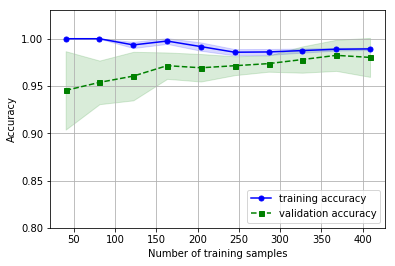

In [11]:
### Bias-variance trade-off 그래프로 확인하기 ###
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2', random_state=1, solver='lbfgs'))
train_sizes, train_scores, test_scores =\
             learning_curve(estimator=pipe_lr, X=X_train, y=y_train,
                            train_sizes=np.linspace(0.1, 1.0, 10), cv=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5,
         label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s',
         markersize=5, label='validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.show()

In [19]:
### Grid search에 의한 초모수 결정 (SVM) ###
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
pipe_svc = make_pipeline(StandardScaler(), SVC(random_state=1))
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']},   #첫번째 폴더
              {'svc__C': param_range, 'svc__gamma': param_range,    #두번째 폴더
               'svc__kernel': ['rbf']}]  
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid,
                  scoring='accuracy', cv=10) # 판별방법은 accuracy 임. sse를 쓰면안됨. sse는 sample size에 결정.
gs = gs.fit(X_train, y_train)
print(gs.best_score_) #얘는 cv에서 얻음.
print(gs.best_params_)

clf = gs.best_estimator_ #가장 최고의 parameter을 적합시킴
clf.fit(X_train, y_train)
clf.score(X_train,y_train)  #얘도 찍어야함. 얘는 결과에서 지금 안보임.
clf.score(X_test, y_test) #얘가 출력됨

0.9846153846153847
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


0.9736842105263158

In [16]:
### Nested cross-validation을 이용한 초모수 결정 ###
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid,
                  scoring='accuracy', cv=3)
scores = cross_val_score(gs, X, y, scoring='accuracy', cv=5)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores))) # 알아서 평균값 구한것. 굉장히 편하다

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


CV accuracy: 0.977 +/- 0.009


In [17]:
# Decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
inner_cv=KFold(n_splits=3, shuffle=True, random_state=0) # KFold를 써도 됨. shuffling을 통해 control이 되므로, kfold의 의미가 있음.
outer_cv=KFold(n_splits=5, shuffle=True, random_state=0) # 잘 정돈된 데이터를 한번 한들어준다.
gs = GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
                  param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7, None]}], #뿌리깊이
                  scoring='accuracy', cv=inner_cv)
scores = cross_val_score(gs, X, y, scoring='accuracy', cv=outer_cv)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores))) # svm이 이긴거.

CV accuracy: 0.942 +/- 0.012
